## Modeling

In this notebook, we will be using Pandas, Numpy, and Sklearn to perform supervised machine learning and build an optimized binary classification model (millenials as home owners or non-homeowners) and Matplotlib and Seaborn to visualize our results.

Note: the other functions used in the notebook will be found in the EDA_Functions.py and Modeling_Functions.py files.




In [10]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
import numpy as np

#import models, scoring, and visualization
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, roc_curve, recall_score, precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

#import my own python modeling and scoring functions
from EDA_Functions import owns_perm_home, bus_or_farm_income
from Modeling_Functions import *

#make sure we can import our .py functions and update in real time
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Modeling with baseline data
Our baseline dataset is very raw. No NaNs filled (ie- negative values that signify skipped questions/nonanswers), no feature engineering. Let's see how our model does with this very raw dataset.

We will plug it into a random forest model for this baseline, because random forest does well with minimal data cleaning, minimal model tuning, straight out of the box.


In [71]:
#load baseline model
baseline_df = pd.read_pickle('joined_df.pickle')

,id,sex,birth_year,sample_type,race,poverty,degree_2017,marriage,metro_area,child_at_home,...,debts_30,house_type_35,fin_assets_35,debts_35,id,childhood_home,childhood_poverty,own_or_rent,home_situation,moves_since_12
0,1,2,1981,1,4,-5,-5,-5,-5,-5,...,18000,-4,-4,-4,1,2,-3,5,1,1
1,2,1,1982,1,2,929,2,2,2,-4,...,35000,1,2000,62500,2,-4,-4,4,-4,-4
2,3,2,1983,1,2,-3,4,3,2,2,...,19300,-4,-4,-4,3,2,583,4,-4,13
3,4,2,1981,1,2,179,2,2,3,1,...,0,6,7050,1300,4,2,108,4,-4,5
4,5,1,1982,1,2,871,2,3,3,2,...,9000,1,300000,3000,5,2,-3,1,-4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7688,9018,2,1980,1,4,327,1,3,2,0,...,1200,1,4000,19000,9018,-4,-3,4,-4,-4
7689,9019,1,1984,0,2,498,3,2,3,0,...,17000,-4,-4,-4,9019,2,-3,5,1,5
7690,9020,1,1980,1,4,-5,-5,-5,-5,-5,...,0,6,78750,0,9020,1,663,5,8,9
7691,9021,1,1980,1,4,260,4,2,2,1,...,0,6,9000,0,9021,2,144,4,-4,13


In [75]:
#create our Y variable
baseline_df['homeowner_perm'] = baseline_df.apply(lambda x: owns_perm_home(x['house_type_30']),axis=1)

In [76]:
baseline_df.columns

Index(['id', 'sex', 'birth_year', 'sample_type', 'race', 'poverty',
       'degree_2017', 'marriage', 'metro_area', 'child_at_home', 'urban_rural',
       'income_wage_total', 'income_wage_est', 'income_bus_total',
       'income_bus_est', 'degree_other', 'house_type_30', 'fin_assets_30',
       'debts_30', 'house_type_35', 'fin_assets_35', 'debts_35', 'id',
       'childhood_home', 'childhood_poverty', 'own_or_rent', 'home_situation',
       'moves_since_12', 'homeowner_perm'],
      dtype='object')

In [437]:
#set X and Y
features = ['sex', 'birth_year', 'race', 'poverty',
       'marriage', 'metro_area', 'child_at_home', 'urban_rural',
       'income_wage_total', 'income_wage_est', 'income_bus_total',
       'income_bus_est', 'degree_other', 'fin_assets_30',
       'debts_30', 'childhood_poverty', 'moves_since_12']

X = baseline_df.loc[:, features]
y = baseline_df['homeowner_perm']

In [438]:
#split into train-val and test, making sure to stratify y so we preserve the class balance in our sample
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)

In [293]:
#testing random forest(no_scaling)
get_score(X_train_val, y_train_val, (RandomForestClassifier(max_depth = 5, class_weight='balanced')))

Accuracy: 0.7278
Train/Test ratio: 1.0598
AUC: 0.7259
Precision: 0.5522
RECALL: 0.7206


Our baseline model looks very good, and we've got the high recall with need. 

We are focusing on **recall** due to the business use case of our model--**we want to reach as many millenial homeowners as we can to cast a wider net.** Precision is important, but recall is our focus in the precision-recall tradeoff, because leaving out a millenial who is a homeowner from marketing/outreach materials (false negative) is **more costly** to us (in terms of a lost customer and the opportunity cost of their business) than reaching a millenial who is not currently a homeowner (false positive).

If we were pressed for time and focused on predictive power, we could just call it a day and go with this data and model. 

However, the use case for our model is for interpretation, so let's see how our thoroughly cleaned and feature engineered data works with models with better interpretability--like logistic regression.

### Modeling with cleaned and feature-engineered data

In [2]:
#load our cleaned dataframe with our feature engineered features
df = pd.read_pickle('final_df.pickle')
df

,id,homeowner_perm,birth_year,is_male,poverty,child_at_home,fin_assets_30,debts_30,moves_since_12,fin_mobility,...,is_metro,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law
1,2,0,1982,1.0,9.29,0.0,45000.0,35000.0,0.0,1.000000,...,1,0,0,0,1,0,0,0,0,0
3,4,0,1981,0.0,1.79,1.0,0.0,0.0,5.0,1.657407,...,1,1,0,0,1,0,0,0,0,0
10,11,0,1982,0.0,3.99,1.0,3000.0,62500.0,8.0,2.015152,...,1,1,0,0,0,0,1,0,0,0
11,12,0,1981,1.0,5.67,1.0,20000.0,15200.0,5.0,1.000000,...,1,1,0,1,0,0,0,0,0,0
14,16,0,1982,1.0,2.40,0.0,3000.0,3000.0,5.0,2.000000,...,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7683,9012,0,1984,0.0,5.57,0.0,200000.0,0.0,14.0,2.886010,...,1,0,1,0,0,0,1,0,0,0
7684,9013,0,1982,1.0,1.40,0.0,1750.0,0.0,8.0,5.833333,...,1,1,0,1,0,0,0,0,0,0
7686,9015,1,1980,0.0,3.25,3.0,88176.0,55464.0,11.0,1.124567,...,1,0,1,0,1,0,0,0,0,0
7687,9016,1,1982,0.0,2.23,0.0,530.0,42400.0,6.0,1.149485,...,1,1,1,0,0,0,1,0,0,0


In [3]:
#adding a total income column
df['total_income'] = df['income_wage_compiled'] + df['income_bus_compiled']

In [4]:
df.columns

Index(['id', 'homeowner_perm', 'birth_year', 'is_male', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'income_wage_compiled', 'income_bus_compiled',
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab',
       'is_metro', 'is_central', 'childhood_owned', 'GED', 'High_School',
       'Assc_College', 'Bachelors', 'Masters', 'PhD', 'Med_Law',
       'total_income'],
      dtype='object')

In [5]:
#set X and Y
features = ['birth_year', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'income_bus_compiled', 'income_wage_compiled','is_male', 
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab', 'is_metro', 
       'is_central', 'childhood_owned', 'GED', 'High_School', 'Assc_College', 
       'Bachelors', 'Masters', 'PhD', 'Med_Law', 'total_income']

X = df.loc[:, features]
y = df['homeowner_perm']

In [6]:
#split into train-val and test, making sure to stratify y
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)


In [295]:
#testing logistic regression (with scaling)
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(class_weight='balanced')))

Accuracy: 0.7155
Train/Test ratio: 1.0132
AUC: 0.7155
Precision: 0.5362
RECALL: 0.7153


In [296]:
#testing random forest(no_scaling)
get_score(X_train_val, y_train_val, (RandomForestClassifier(max_depth = 5, class_weight='balanced')))

Accuracy: 0.7355
Train/Test ratio: 1.0532
AUC: 0.7335
Precision: 0.5624
RECALL: 0.7280


In [297]:
#testing KNN (with scaling)
get_score_scaled(X_train_val, y_train_val, (KNeighborsClassifier()))

Accuracy: 0.7129
Train/Test ratio: 1.1276
AUC: 0.6506
Precision: 0.5504
RECALL: 0.4825


In [298]:
#testing XGboost(no_scaling)
get_score(X_train_val, y_train_val, (GradientBoostingClassifier()))

Accuracy: 0.7712
Train/Test ratio: 1.0865
AUC: 0.7060
Precision: 0.6736
RECALL: 0.5302


Logistic Classification and Random Forest gave us very pretty good accuracy and great recall scores, however, KNN and XGboost did not give us good recall scores. We weren't able to easily balance class weights while running these models, so let's use some other techniques to do so:

### Oversampling

**KNN**

In [299]:
#oversampling with KNN
get_score_scaled_oversampled(X_train_val, y_train_val, KNeighborsClassifier(), RandomOverSampler())

Accuracy: 0.6576
Train/Test ratio: 1.2461
AUC: 0.6563
Precision: 0.4689
RECALL: 0.6529


In [300]:
#withut oversampling for KNN--for comparision
get_score_scaled(X_train_val, y_train_val, KNeighborsClassifier())

Accuracy: 0.7129
Train/Test ratio: 1.1276
AUC: 0.6506
Precision: 0.5504
RECALL: 0.4825


Oversampling doesn't make much of a difference with KNN. It's the model that consistently does the worst for us.

**Gradient Boost**

In [301]:
#oversample with Gradient Boost
get_score_oversampled(X_train_val, y_train_val, GradientBoostingClassifier(), RandomOverSampler())

Accuracy: 0.7405
Train/Test ratio: 1.1114
AUC: 0.7337
Precision: 0.5701
RECALL: 0.7153


In [302]:
#without oversample for comparison
get_score(X_train_val, y_train_val, GradientBoostingClassifier())

Accuracy: 0.7712
Train/Test ratio: 1.0865
AUC: 0.7060
Precision: 0.6736
RECALL: 0.5302


The oversampler made a huge difference for gradient boost--allowing us to have a much higher recall score.

**Logistic Regression**

In [303]:
get_score_scaled_oversampled(X_train_val, y_train_val, (LogisticRegression()), RandomOverSampler())

Accuracy: 0.7155
Train/Test ratio: 1.0151
AUC: 0.7160
Precision: 0.5367
RECALL: 0.7175


In [304]:
#testing logistic regression (with scaling)
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(class_weight='balanced')))

Accuracy: 0.7155
Train/Test ratio: 1.0132
AUC: 0.7155
Precision: 0.5362
RECALL: 0.7153


Oversampling compared to just balancing class weights in the model for logistic regression doesn't lead us to better scores--they're more or less the same.

**Random Forest**

In [305]:
get_score_oversampled(X_train_val, y_train_val, RandomForestClassifier(max_depth = 5), RandomOverSampler())

Accuracy: 0.7275
Train/Test ratio: 1.0784
AUC: 0.7271
Precision: 0.5517
RECALL: 0.7259


In [306]:
get_score(X_train_val, y_train_val, RandomForestClassifier(max_depth = 5, class_weight= 'balanced'))

Accuracy: 0.7345
Train/Test ratio: 1.0559
AUC: 0.7302
Precision: 0.5611
RECALL: 0.7185


Similar to logistic regression, oversampling compared to just balancing class weights in the model for random forest doesn't lead us to better scores--they're more or less the same.

Since our goal is still interpretabilty, we want to optimize logistic regression--which gives us features and their coefficients. **We wanted to match the predictive power of tree based models through logistic regression, which we have done through thorough data cleaning and feature engineering.**

Logistic Regression  performed basically as well as Random Forest and is much more interpretable, which we need for the use case of our model. Since oversampling doesn't impact Logistic Regression, we won't be oversampling as we optimize the features.

### Parameter Tuning

Let's see if we can further optimize our Logistic Regression model through parameter tuning--especially regularization.

Below are our default parameters for reference:

In [318]:
#our default
#testing logistic regression, with scaling, balanced class weights - default = L2 Ridge
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(class_weight='balanced')))

Accuracy: 0.7155
Train/Test ratio: 1.0132
AUC: 0.7155
Precision: 0.5362
RECALL: 0.7153


Our default uses L2 regularization--Ridge. 

So let's try L1 - Lasso, especially since we have many features and would welcome minimizing our number of features (data collection is time consuming and costly, so the fewer features we have, the better).

In [317]:
#testing logistic regression, with scaling, balanced class weights, and L1 regularization penalty
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')))

Accuracy: 0.7149
Train/Test ratio: 1.0128
AUC: 0.7155
Precision: 0.5354
RECALL: 0.7175


We're not seeing a big difference, so let's try to adjusting the strength of our regularization. First, let's try a random heavier regularization strength:

In [324]:
#testing logistic regression, with scaling, balanced class weights, and L1 regularization penalty-- Lasso -- with an increased regularization strength (default is 1 and the lower teh value, the greater the regularization force)
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.5,solver='liblinear', class_weight='balanced')))

Accuracy: 0.7155
Train/Test ratio: 1.0107
AUC: 0.7166
Precision: 0.5362
RECALL: 0.7196


That improved our scores! Now let's see if we can run a loop to optimize our regularization strength:

In [342]:
#prints each value of C, from 0 - 1, skipping by 0.1 at a time, and our model scores.
for i in np.arange(0.1, 1, 0.1):
    c_value = i 
    log_model = get_score_scaled(X_train_val, y_train_val, (LogisticRegression  (penalty='l1', C=c_value,solver='liblinear', class_weight='balanced')))
    print(c_value)
   
    

Accuracy: 0.7115
Train/Test ratio: 1.0097
AUC: 0.7143
Precision: 0.5311
RECALL: 0.7217
0.1
Accuracy: 0.7125
Train/Test ratio: 1.0110
AUC: 0.7144
Precision: 0.5325
RECALL: 0.7196
0.2
Accuracy: 0.7149
Train/Test ratio: 1.0096
AUC: 0.7164
Precision: 0.5352
RECALL: 0.7206
0.30000000000000004
Accuracy: 0.7152
Train/Test ratio: 1.0112
AUC: 0.7172
Precision: 0.5356
RECALL: 0.7228
0.4
Accuracy: 0.7155
Train/Test ratio: 1.0107
AUC: 0.7166
Precision: 0.5362
RECALL: 0.7196
0.5
Accuracy: 0.7145
Train/Test ratio: 1.0124
AUC: 0.7153
Precision: 0.5350
RECALL: 0.7175
0.6
Accuracy: 0.7149
Train/Test ratio: 1.0121
AUC: 0.7155
Precision: 0.5354
RECALL: 0.7175
0.7000000000000001
Accuracy: 0.7145
Train/Test ratio: 1.0132
AUC: 0.7153
Precision: 0.5350
RECALL: 0.7175
0.8
Accuracy: 0.7149
Train/Test ratio: 1.0125
AUC: 0.7155
Precision: 0.5354
RECALL: 0.7175
0.9


In [7]:
#testing logistic regression, with scaling, balanced class weights, and L1 regularization penalty-- Lasso -- with an increased regularization strength (default is 1 and the lower teh value, the greater the regularization force)
#optimial value 0.4
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')))

Accuracy: 0.7152
Train/Test ratio: 1.0111
AUC: 0.7172
Precision: 0.5356
RECALL: 0.7228


In [11]:
#get coefficients for this optimized model
get_coef(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')))

[('moves_since_12', -0.468324521440353),
 ('is_married', 0.43897732736994044),
 ('fin_assets_30', 0.37429547192999113),
 ('Bachelors', 0.32081662353834783),
 ('is_black', -0.2893246193047619),
 ('Masters', 0.24839967222094556),
 ('total_income', 0.1982272557224623),
 ('is_hispanic', -0.18731060873758362),
 ('childhood_owned', 0.185522789685513),
 ('is_cohab', 0.17447835925540522),
 ('High_School', 0.16747317440704326),
 ('Assc_College', 0.1515278739568698),
 ('child_at_home', 0.10703035162911867),
 ('GED', 0.09485308992199018),
 ('debts_30', 0.08486118662130848),
 ('Med_Law', 0.08003774098229396),
 ('fin_mobility', 0.07568754121927182),
 ('is_male', -0.052432589192168304),
 ('poverty', -0.05199739656763574),
 ('is_mixed', -0.030280476443447894),
 ('PhD', -0.022851715022279978),
 ('is_central', 0.020608629654573395),
 ('birth_year', -0.012284418518827335),
 ('is_metro', -0.005877701293487262),
 ('income_bus_compiled', 0.005152387917908285),
 ('income_wage_compiled', 0.0)]

This optimal regularization and coefficients tells us we can actually drop the last feature income_wage_compiled with coefficient 0, so let's do that for our final model:

In [374]:
#set X and Y
#remove income_wage_compiled from our original features
features = ['birth_year', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'income_bus_compiled','is_male', 
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab', 'is_metro', 
       'is_central', 'childhood_owned', 'GED', 'High_School', 'Assc_College', 
       'Bachelors', 'Masters', 'PhD', 'Med_Law', 'total_income']

X = df.loc[:, features]
y = df['homeowner_perm']

In [375]:
#split into train-val and test, making sure to stratify y
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)

In [376]:
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')))

Accuracy: 0.7152
Train/Test ratio: 1.0111
AUC: 0.7172
Precision: 0.5356
RECALL: 0.7228


Our second least important feature--income-bus_compiled--is included in total_income, so let's see if our model can be improved by us turning that into a boolean--1 for business/farm income, 0 for no business income

In [12]:
#create a boolean feature for business/farm income
df['bus_income'] = df.apply(lambda x: bus_or_farm_income(x['income_bus_compiled']),axis=1)

Now let's set up our X and Y, filling in bus_income boolean for the income_bus_compiled variable.

In [13]:
#set X and Y
#remove income_wage_compiled from our original features
features = ['birth_year', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'bus_income','is_male', 
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab', 'is_metro', 
       'is_central', 'childhood_owned', 'GED', 'High_School', 'Assc_College', 
       'Bachelors', 'Masters', 'PhD', 'Med_Law', 'total_income']

X = df.loc[:, features]
y = df['homeowner_perm']

In [14]:
#split into train-val and test, making sure to stratify y
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)

In [15]:
get_score_scaled(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')))

Accuracy: 0.7159
Train/Test ratio: 1.0101
AUC: 0.7171
Precision: 0.5365
RECALL: 0.7206


Our scores have remained the same and we our new feature allows for more ease of data collection--asking for total income and whether a part of it comes from a business/farm as opposed to asking for separate wage and business incomes. 

**This is our final, optimized, very interpretable model**

In [17]:
#get coefficients for this final model
coef = get_coef(X_train_val, y_train_val, (LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')))
coef

[('moves_since_12', -0.4672568658726698),
 ('is_married', 0.4383645008718921),
 ('fin_assets_30', 0.37503518097211996),
 ('Bachelors', 0.3204503356666942),
 ('is_black', -0.2895226120561321),
 ('Masters', 0.2483304808981693),
 ('total_income', 0.2044354213009472),
 ('is_hispanic', -0.1885433192813819),
 ('childhood_owned', 0.18570360491483998),
 ('is_cohab', 0.17446708525386898),
 ('High_School', 0.16930428256673363),
 ('Assc_College', 0.15226453945914561),
 ('child_at_home', 0.10673763097873322),
 ('GED', 0.09763921227058167),
 ('debts_30', 0.08394221312059817),
 ('Med_Law', 0.07814939043702943),
 ('fin_mobility', 0.07573851933954495),
 ('is_male', -0.05204612908130916),
 ('poverty', -0.04913462505217771),
 ('bus_income', -0.03535907257735846),
 ('is_mixed', -0.029659311526111013),
 ('PhD', -0.023934883715443188),
 ('is_central', 0.0216580949983562),
 ('birth_year', -0.013360132776905285),
 ('is_metro', -0.00599363801918709)]

In [562]:
turn features into a dataframe for visuals 
features = pd.DataFrame(coef)
features.rename(columns = {0: 'Feature', 1: "Coefficient"}, inplace = True)
features

,Feature,Coefficient
0,moves_since_12,-0.467258
1,is_married,0.438365
2,fin_assets_30,0.375036
3,Bachelors,0.320441
4,is_black,-0.289522
5,Masters,0.248324
6,total_income,0.204438
7,is_hispanic,-0.188543
8,childhood_owned,0.185701
9,is_cohab,0.174468


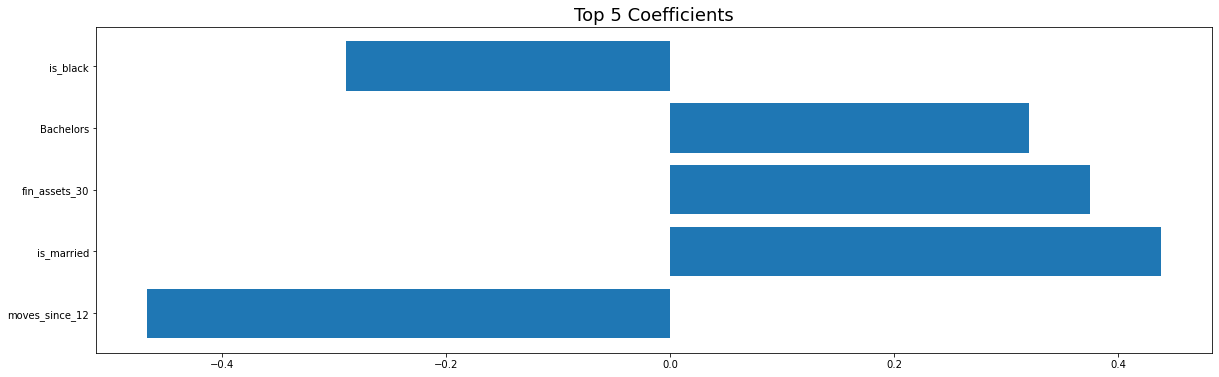

In [568]:
plt.figure(figsize = (20,6))
plt.barh(features['Feature'][0:5], width = features['Coefficient'][0:5], align = 'center')
plt.title('Top 5 Coefficients', fontsize = 18);

### Testing and visualization

In [582]:
#set X and Y
#final dataframe and features
features = ['birth_year', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'bus_income','is_male', 
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab', 'is_metro', 
       'is_central', 'childhood_owned', 'GED', 'High_School', 'Assc_College', 
       'Bachelors', 'Masters', 'PhD', 'Med_Law', 'total_income']

X = df.loc[:, features]
y = df['homeowner_perm']

In [583]:
#split into train-val and test, making sure to stratify y
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)

In [584]:
final_model = LogisticRegression(penalty='l1', C=0.4,solver='liblinear', class_weight='balanced')

#Scale data
ss = StandardScaler()
#fit transform X train_val
X_train_val_scaled = ss.fit_transform(X_train_val)
#transform X test
X_test_scaled = ss.transform(X_test)
#fit model
final_model.fit(X_train_val_scaled, y_train_val)
#make prediction 
y_pred = final_model.predict(X_test_scaled)
y_pred_prob = final_model.predict_proba(X_test_scaled)[:,1]

#get accuracy scores for train_val and test
acc_train = final_model.score(X_train_val_scaled, y_train_val)
acc_test = final_model.score(X_test_scaled, y_test)

#get scores on precision, recall, and auc
auc_score = roc_auc_score(y_test, y_pred_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


#print our accuracy score, our train/test ratio precision, and recall, and auc score
print(f'Accuracy: {acc_test:.4f}')
print(f'Train/Test ratio: {(acc_train)/(acc_test):.4f}')

print(f'AUC: {auc_score:.4f}')
print(f'Precision: {precision:.4f}')
print(f'RECALL: {recall:.4f}')




Accuracy: 0.7137
Train/Test ratio: 1.0119
AUC: 0.7771
Precision: 0.5342
RECALL: 0.7257


Our final test scores look great! <br/>  Let's plot out our confusion matrix:

In [601]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[367, 147],
       [ 65, 172]])

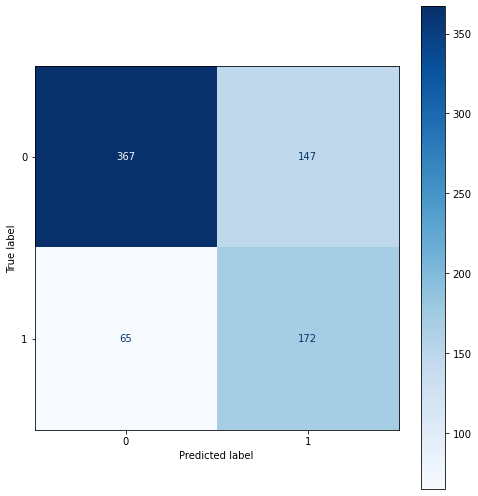

In [607]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(final_model, X_test_scaled, y_test, ax=ax, cmap = 'Blues')
plt.tight_layout()
plt.savefig('confusion matrix.png', dpi=300);

### Precision v Recall

Now let's plot our ROC curve:

<Figure size 1080x1080 with 0 Axes>

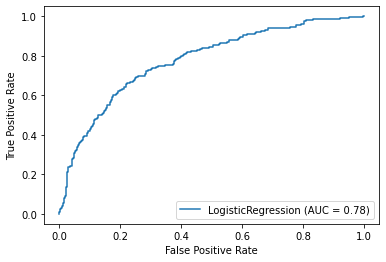

In [585]:
plt.figure(figsize=(15, 15))
plot_roc_curve(final_model, X_test_scaled, y_test)
plt.show();

Let's plot our precision recall curves to think about the optimial convergence point and how that relates to trade off. Even though they opimial for both is around 0.6 for threshold, we are trying to prioritize recall, so our default threshold (0.5) works for our model.

(0.0, 1.0)

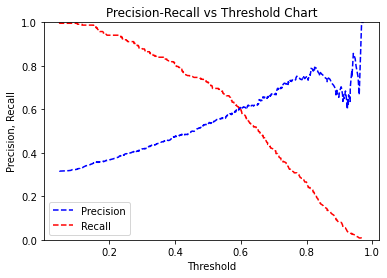

In [581]:
### Plot my precision recall curve

pred_y=final_model.predict(X_test_scaled) 

probs_y=final_model.predict_proba(X_test_scaled) 

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
   #retrieve probability of being 1(in second column of probs_y)
#pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

### Exporting Predictions for Tableau

We want to make a tableau dashboard with our predictions in order to further visualize our data. Let's create a new dataframe with all of our original features and add in our predictions.

In [546]:
tableau_df = X_test.copy()

In [547]:
#join our test dataframe with our TRUE y
tableau_df = tableau_df.join(y_test)

In [548]:
#create a new column for our Y predictions in our test dataframe
tableau_df['Predictions']=y_pred 

In [549]:
#create a new column for predict probability 1 in X_test df
tableau_df['Predict_Proba_1'] = final_model.predict_proba(X_test_scaled)[:,1]

In [550]:
#create a new column for predict probability 0 in X_test df
tableau_df['Predict_Proba_0'] = final_model.predict_proba(X_test_scaled)[:,0]

In [551]:
tableau_df


,birth_year,poverty,child_at_home,fin_assets_30,debts_30,moves_since_12,fin_mobility,bus_income,is_male,is_black,...,Assc_College,Bachelors,Masters,PhD,Med_Law,total_income,homeowner_perm,Predictions,Predict_Proba_1,Predict_Proba_0
6194,1984,1.05,5.0,500.0,7000.0,13.0,1.810345,0,0.0,1.0,...,0,0,0,0,0,9000.0,1,0,0.343282,0.656718
1509,1981,11.01,0.0,165000.0,0.0,9.0,1.221976,0,0.0,0.0,...,0,1,0,0,0,50000.0,1,1,0.866744,0.133256
4146,1982,2.59,1.0,64500.0,11500.0,5.0,1.681818,0,1.0,0.0,...,0,0,1,0,0,50000.0,0,1,0.840869,0.159131
5580,1982,23.03,1.0,10000.0,100.0,0.0,1.000000,0,0.0,0.0,...,0,0,0,0,0,35000.0,0,1,0.559271,0.440729
1228,1982,1.97,2.0,4200.0,0.0,16.0,0.230950,0,0.0,0.0,...,0,0,0,0,0,5000.0,0,0,0.460850,0.539150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,1983,5.53,0.0,11000.0,28500.0,7.0,1.755556,0,1.0,0.0,...,0,0,1,0,0,69000.0,1,0,0.492721,0.507279
6029,1981,7.53,0.0,17000.0,1000.0,15.0,9.531646,0,1.0,0.0,...,1,0,0,0,0,63000.0,0,0,0.329807,0.670193
759,1982,8.73,0.0,14000.0,12000.0,12.0,2.890728,0,0.0,1.0,...,0,1,0,0,0,75000.0,1,1,0.503637,0.496363
498,1983,0.75,4.0,4800.0,332.0,17.0,0.250000,0,0.0,0.0,...,0,0,0,0,0,24000.0,0,0,0.340167,0.659833


In [552]:
df.columns

Index(['id', 'homeowner_perm', 'birth_year', 'is_male', 'poverty',
       'child_at_home', 'fin_assets_30', 'debts_30', 'moves_since_12',
       'fin_mobility', 'income_wage_compiled', 'income_bus_compiled',
       'is_black', 'is_hispanic', 'is_mixed', 'is_married', 'is_cohab',
       'is_metro', 'is_central', 'childhood_owned', 'GED', 'High_School',
       'Assc_College', 'Bachelors', 'Masters', 'PhD', 'Med_Law',
       'total_income', 'bus_income'],
      dtype='object')

In [553]:
#create id column from origina df to join to tableau df for visualization
df_ids = df['id']
tableau_df = tableau_df.join(df_ids)


In [554]:
cols = tableau_df.columns.tolist()
cols

['birth_year',
 'poverty',
 'child_at_home',
 'fin_assets_30',
 'debts_30',
 'moves_since_12',
 'fin_mobility',
 'bus_income',
 'is_male',
 'is_black',
 'is_hispanic',
 'is_mixed',
 'is_married',
 'is_cohab',
 'is_metro',
 'is_central',
 'childhood_owned',
 'GED',
 'High_School',
 'Assc_College',
 'Bachelors',
 'Masters',
 'PhD',
 'Med_Law',
 'total_income',
 'homeowner_perm',
 'Predictions',
 'Predict_Proba_1',
 'Predict_Proba_0',
 'id']

In [555]:
#re-index columns 

cols.insert(0, cols.pop(cols.index('id')))
cols.insert(1, cols.pop(cols.index('homeowner_perm')))
cols.insert(2, cols.pop(cols.index('Predictions')))
cols.insert(3, cols.pop(cols.index('Predict_Proba_1')))
cols.insert(4, cols.pop(cols.index('Predict_Proba_0')))
tableau_df= tableau_df.reindex(columns= cols)


In [557]:
#rename columns for easier visualization
tableau_df = tableau_df.rename(columns={"homeowner_perm": "Y_true", "Predictions": "Y_pred", "Predict_Proba_1": "Pred_Prob_1", "Predict_Proba_0": "Pred_Prob_0"})

In [558]:
tableau_df

,id,Y_true,Y_pred,Pred_Prob_1,Pred_Prob_0,birth_year,poverty,child_at_home,fin_assets_30,debts_30,...,is_central,childhood_owned,GED,High_School,Assc_College,Bachelors,Masters,PhD,Med_Law,total_income
6194,7327,1,0,0.343282,0.656718,1984,1.05,5.0,500.0,7000.0,...,0,0,1,0,0,0,0,0,0,9000.0
1509,1837,1,1,0.866744,0.133256,1981,11.01,0.0,165000.0,0.0,...,0,1,0,0,0,1,0,0,0,50000.0
4146,4943,0,1,0.840869,0.159131,1982,2.59,1.0,64500.0,11500.0,...,1,1,0,0,0,0,1,0,0,50000.0
5580,6627,0,1,0.559271,0.440729,1982,23.03,1.0,10000.0,100.0,...,0,0,1,0,0,0,0,0,0,35000.0
1228,1489,0,0,0.460850,0.539150,1982,1.97,2.0,4200.0,0.0,...,0,1,0,1,0,0,0,0,0,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2710,1,0,0.492721,0.507279,1983,5.53,0.0,11000.0,28500.0,...,1,1,0,0,0,0,1,0,0,69000.0
6029,7153,0,0,0.329807,0.670193,1981,7.53,0.0,17000.0,1000.0,...,1,0,0,0,1,0,0,0,0,63000.0
759,924,1,1,0.503637,0.496363,1982,8.73,0.0,14000.0,12000.0,...,0,1,0,0,0,1,0,0,0,75000.0
498,605,0,0,0.340167,0.659833,1983,0.75,4.0,4800.0,332.0,...,0,0,1,0,0,0,0,0,0,24000.0


In [559]:
#pickle df
tableau_df.to_pickle("tableau_df.pickle")

In [560]:
#turn df into csv
tableau_df.to_csv('/Users/juliaqiao/Documents/Metis/Project_3/tableau.csv', index=False)


Check out my tableau (Project_3.twb) for a final visualization.